In [9]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import Lars
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')


In [936]:
def get_orthogonal_vec(vec):
    """Get one (of potentially many) orthogonal vectors to input"""
    dim = len(vec)
    basis_idx = np.argmin(np.abs(np.identity(dim) @ vec))
    basis_vec = np.zeros(dim)
    basis_vec[basis_idx] += 1
    return basis_vec - (basis_vec @ vec) * vec


def generate_data(dim, corpus_size, num_sv, seed):
    """Generate a dataset with a single test point on one 
    side of a half space, the remaining points on the other side
    or the hyperplane itself. Then the nearest point on the convex
    hull of the non-test set examples is located at [1,1, ... , 1]
    
    Args:
        dim (int): number of dimensions.
        corpus_size (int): number of datapoints in corpus.
        num_sv (1 or 2): number of support vectors.
        seed (int): random seed
    """
    bias = np.array(dim*[1])
    np.random.seed(seed)
    H = np.random.normal(size=dim)
    H /= np.sum(H**2)**0.5

    if num_sv == 1:
        data = [np.array(dim*[0]) + bias]
    else:
        # note that H is orthogonal to the hyperplane
        data = [get_orthogonal_vec(H) + bias, - get_orthogonal_vec(H) + bias]

    while True:
        new_point = np.random.normal(size=dim)
        if H @ new_point < 0:
            data.append(new_point + bias)
        if len(data) == corpus_size:
            break
    test_point = H + bias 
    
    return np.vstack(data), test_point

def fit_simplex_np(corpus, test_point, n_keep):
    corpus_t = torch.tensor(corpus, dtype=torch.float32)
    test_point_t = torch.tensor(test_point, dtype=torch.float32).unsqueeze(0)
    simplex = Simplex(corpus_t)
    simplex.fit(test_point_t, n_epoch = 10000, n_keep=n_keep)
    approx = simplex.weights @ simplex.corpus_latent_reps
    approx_np = approx.numpy()
    weights_np = simplex.weights.numpy()
    return approx_np[0], weights_np[0]

def euclid_dist(a, b):
    return ((a - b)**2).sum()**0.5

def run_n_iter(n, dim, corpus_size, num_sv, n_keep_prior=None):
    n_keep = n_keep_prior if n_keep_prior else num_sv
    decom_loss = []
    decom_weights_loss = []
    simplex_loss = []
    simplex_weights_loss = []
    for s in range(n):
        corpus, test_point = generate_data(dim, corpus_size, num_sv, seed=s)
        proj_hull_, weights_ = corpus_decomposition(corpus, test_point)
        proj_hull, weights = fit_simplex_np(corpus, test_point, n_keep=n_keep)
        
        decom_loss.append(euclid_dist(proj_hull_, 1))
        simplex_loss.append(euclid_dist(proj_hull, 1))
        decom_weights_loss.append(euclid_dist(weights_[:num_sv], np.array(num_sv*[1/num_sv])))
        simplex_weights_loss.append(euclid_dist(weights[:num_sv], np.array(num_sv*[1/num_sv])))
        
    return decom_loss, simplex_loss, decom_weights_loss, simplex_weights_loss


In [945]:
# optimal separating hyperplane method

def corpus_decomposition(H: np.array, h: list):
    """
    H (np.array): corpus latent representations of shape (num_corpus_examples, num_latent_dim).
    h (list): test latent representation of length num_latent_dim. 
    """
    
    size_corpus = H.shape[0]
    X = np.vstack([H, h])
    y = np.repeat([1,-1], [size_corpus, 1])
    
    svm = SVC(kernel="linear", C=1000, tol=1e-5)
    svm.fit(X, y)

    y_alpha = svm.dual_coef_
    weights = y_alpha[0][1:] /y_alpha[0][1:].sum()
    proj_hull = weights @ X[svm.support_[1:]]
    
    w_idx = svm.support_[1:] # corresponding indices from the original corpus
    all_weights = np.zeros(size_corpus)
    np.add.at(all_weights, w_idx, weights)
    
    return proj_hull, all_weights



class Simplex:
    def __init__(self, corpus_latent_reps: torch.Tensor) -> None:
        """
        Initialize a SimplEx explainer
        :param corpus_examples: corpus input features
        :param corpus_latent_reps: corpus latent representations
        """
        self.corpus_latent_reps = corpus_latent_reps
        self.corpus_size = corpus_latent_reps.shape[0]
        self.dim_latent = corpus_latent_reps.shape[-1]
        self.weights = None
        self.n_test = None
        self.hist = None
        self.test_examples = None
        self.test_latent_reps = None
        self.jacobian_projections = None

    def fit(self, test_latent_reps: torch.Tensor,
            n_epoch: int = 10000, reg_factor: float = 1.0, n_keep: int = 2, reg_factor_scheduler=None) -> None:
        """
        Fit the SimplEx explainer on test examples
        :param test_examples: test example input features
        :param test_latent_reps: test example latent representations
        :param n_keep: number of neighbours used to build a latent decomposition
        :param n_epoch: number of epochs to fit the SimplEx
        :param reg_factor: regularization prefactor in the objective to control the number of allowed corpus members
        :param n_keep: number of corpus members allowed in the decomposition
        :param reg_factor_scheduler: scheduler for the variation of the regularization prefactor during optimization
        :return:
        """
        n_test = test_latent_reps.shape[0]
        preweights = torch.zeros((n_test, self.corpus_size), device=test_latent_reps.device, requires_grad=True)
        optimizer = torch.optim.Adam([preweights])
        hist = np.zeros((0, 2))
        for epoch in range(n_epoch):
            optimizer.zero_grad()
            weights = F.softmax(preweights, dim=-1)
            corpus_latent_reps = torch.einsum('ij,jk->ik', weights, self.corpus_latent_reps)
            error = ((corpus_latent_reps - test_latent_reps) ** 2).sum()
            weights_sorted = torch.sort(weights)[0]
            regulator = (weights_sorted[:, : (self.corpus_size - n_keep)]).sum()
            loss = error + reg_factor * regulator
            loss.backward()
            optimizer.step()
            if reg_factor_scheduler:
                reg_factor = reg_factor_scheduler.step(reg_factor)
            hist = np.concatenate((hist,
                                   np.array([error.item(), regulator.item()]).reshape(1, 2)),
                                  axis=0)
        self.weights = torch.softmax(preweights, dim=-1).detach()
        self.test_latent_reps = test_latent_reps
        self.n_test = n_test
        self.hist = hist
 

In [946]:
default_dim = 50
default_corpus_size = 1000
default_num_sv = 2
n_iter = 20

dimensions = [20, 40, 60, 80, 100]

# store results
mean_decom_loss_ls = []
std_decom_loss_ls = []
mean_simplex_loss_ls = []
std_simplex_loss_ls = []
mean_decom_weights_loss_ls = []
std_decom_weights_loss_ls = []
mean_simplex_weights_loss_ls = []
std_simplex_weights_loss_ls = []

for d in dimensions:
    print(f'Working on d = {d}')
    results = run_n_iter(n_iter, d, default_corpus_size, default_num_sv)
    decom_loss, simplex_loss, decom_weights_loss, simplex_weights_loss = results
    mean_decom_loss_ls.append(np.mean(decom_loss))
    std_decom_loss_ls.append(np.std(decom_loss))
    mean_simplex_loss_ls.append(np.mean(simplex_loss))
    std_simplex_loss_ls.append(np.std(simplex_loss))
    mean_decom_weights_loss_ls.append(np.mean(decom_weights_loss))
    std_decom_weights_loss_ls.append(np.std(decom_weights_loss))
    mean_simplex_weights_loss_ls.append(np.mean(simplex_weights_loss))
    std_simplex_weights_loss_ls.append(np.std(simplex_weights_loss))
print('Done')  

Working on d = 20
Working on d = 40
Working on d = 60
Working on d = 80
Working on d = 100
Done


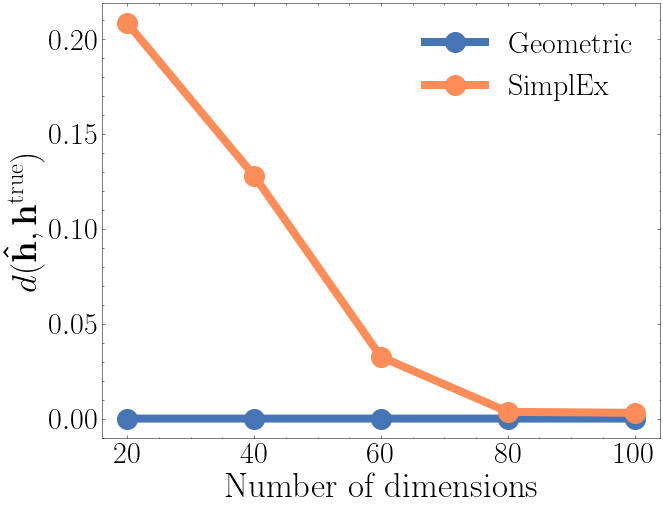

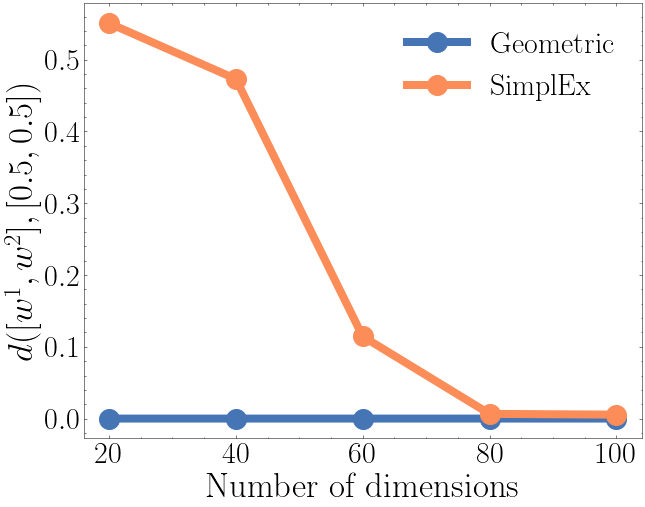

In [948]:
markersize = 20
linewidth = 8
fontsize= 30
labelsize = 35
legendsize = 30

plt.figure(figsize=(10,8))
# plt.title('Approx loss')
plt.xlabel('Number of dimensions', fontsize=labelsize)
plt.ylabel(r'$d(\mathbf{\hat{h}}, \mathbf{h^{\text{true}}})$', fontsize=labelsize)
plt.yticks(fontsize=fontsize)
plt.xticks(dimensions, dimensions, fontsize=fontsize)
plt.plot(dimensions, mean_decom_loss_ls, label='Geometric', marker='o', c='#4575b4',
         markersize=markersize, linewidth=linewidth)
plt.plot(dimensions, mean_simplex_loss_ls, label='SimplEx', marker='o', c='#fc8d59',
         markersize=markersize, linewidth=linewidth)
plt.legend(prop={'size': legendsize})
plt.savefig(f'dims_error.pdf', format='pdf', dpi=1200)
plt.show()

plt.figure(figsize=(10,8))
# plt.title('Weight loss')
plt.xlabel('Number of dimensions', fontsize=labelsize)
plt.ylabel(r'$d([w^1, w^2], [0.5, 0.5])$', fontsize=labelsize)
plt.yticks(fontsize=fontsize)
plt.xticks(dimensions, dimensions, fontsize=fontsize)
plt.plot(dimensions, mean_decom_weights_loss_ls, label='Geometric', marker='o', c='#4575b4',
         markersize=markersize, linewidth=linewidth)
plt.plot(dimensions, mean_simplex_weights_loss_ls, label='SimplEx', marker='o', c='#fc8d59',
         markersize=markersize, linewidth=linewidth)
plt.legend(prop={'size': legendsize})
plt.savefig(f'dims_weights.pdf', format='pdf', dpi=1200)
plt.show()


In [949]:
default_dim = 50
default_corpus_size = 1000
default_num_sv = 2
n_iter = 20

corpus_sizes = [500, 1000, 1500, 2000, 2500]

# store results
mean_decom_loss_ls = []
std_decom_loss_ls = []
mean_simplex_loss_ls = []
std_simplex_loss_ls = []
mean_decom_weights_loss_ls = []
std_decom_weights_loss_ls = []
mean_simplex_weights_loss_ls = []
std_simplex_weights_loss_ls = []

for c in corpus_sizes:
    print(f'Working on c = {c}')
    results = run_n_iter(n_iter, default_dim, c, default_num_sv)
    decom_loss, simplex_loss, decom_weights_loss, simplex_weights_loss = results
    mean_decom_loss_ls.append(np.mean(decom_loss))
    std_decom_loss_ls.append(np.std(decom_loss))
    mean_simplex_loss_ls.append(np.mean(simplex_loss))
    std_simplex_loss_ls.append(np.std(simplex_loss))
    mean_decom_weights_loss_ls.append(np.mean(decom_weights_loss))
    std_decom_weights_loss_ls.append(np.std(decom_weights_loss))
    mean_simplex_weights_loss_ls.append(np.mean(simplex_weights_loss))
    std_simplex_weights_loss_ls.append(np.std(simplex_weights_loss))
print('Done')  

Working on c = 500
Working on c = 1000
Working on c = 1500
Working on c = 2000
Working on c = 2500
Done


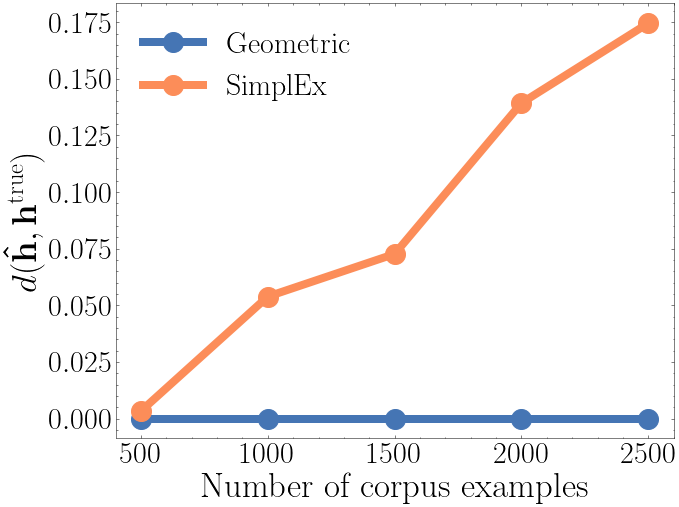

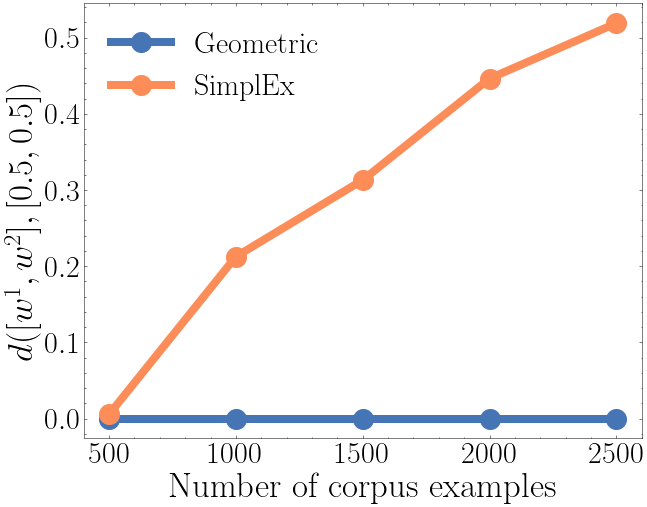

In [951]:
markersize = 20
linewidth = 8
fontsize= 30
labelsize = 35
legendsize = 30

plt.figure(figsize=(10,8))
# plt.title('Approx loss')
plt.xlabel('Number of corpus examples', fontsize=labelsize)
plt.ylabel(r'$d(\mathbf{\hat{h}}, \mathbf{h^{\text{true}}})$', fontsize=labelsize)
plt.yticks(fontsize=fontsize)
plt.xticks(corpus_sizes, corpus_sizes, fontsize=fontsize)
plt.plot(corpus_sizes, mean_decom_loss_ls, label='Geometric', marker='o', c='#4575b4',
         markersize=markersize, linewidth=linewidth)
plt.plot(corpus_sizes, mean_simplex_loss_ls, label='SimplEx', marker='o', c='#fc8d59',
         markersize=markersize, linewidth=linewidth)
plt.legend(prop={'size': legendsize})
plt.savefig(f'corpus_size_error.pdf', format='pdf', dpi=1200)
plt.show()

plt.figure(figsize=(10,8))
# plt.title('Weight loss')
plt.xlabel('Number of corpus examples', fontsize=labelsize)
plt.ylabel(r'$d([w^1, w^2], [0.5, 0.5])$', fontsize=labelsize)
plt.yticks(fontsize=fontsize)
plt.xticks(corpus_sizes, corpus_sizes, fontsize=fontsize)
plt.plot(corpus_sizes, mean_decom_weights_loss_ls, label='Geometric', marker='o', c='#4575b4',
         markersize=markersize, linewidth=linewidth)
plt.plot(corpus_sizes, mean_simplex_weights_loss_ls, label='SimplEx', marker='o', c='#fc8d59',
         markersize=markersize, linewidth=linewidth)
plt.legend(prop={'size': legendsize})
plt.savefig(f'corpus_size_weights.pdf', format='pdf', dpi=1200)
plt.show()


In [952]:
# if uncertainty should be included

# plt.figure(figsize=(10,8))
# plt.title('Approx loss')
# plt.xlabel('Number of corpus examples')
# plt.ylabel('Loss')
# plt.errorbar(corpus_sizes, mean_decom_loss_ls, np.array(std_decom_loss_ls)/2,
#              marker='o', label='Geometric', c='#4575b4',
#              markersize=markersize, linewidth=linewidth)
# plt.errorbar(corpus_sizes, mean_simplex_loss_ls, np.array(std_simplex_loss_ls)/2,
#              marker='o', label='Simplex', c='#fc8d59',
#              markersize=markersize, linewidth=linewidth)
# # plt.plot(mean_simplex_loss_ls, linestyle='--', marker='o', label='Simplex')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10,8))
# plt.title('Weight loss')
# plt.xlabel('Number of corpus examples')
# plt.ylabel('Loss')
# plt.errorbar(corpus_sizes, mean_decom_weights_loss_ls, np.array(std_decom_weights_loss_ls)/2, 
#              linestyle='--', marker='o', label='Decomposition', lolims=0)
# plt.errorbar(corpus_sizes, mean_simplex_weights_loss_ls, np.array(std_simplex_weights_loss_ls)/2, 
#              linestyle='--', marker='o', label='Simplex', lolims=0)
# # plt.plot(corpus_sizes, mean_decom_weights_loss_ls, linestyle='--', marker='o', label='Decomposition')
# # plt.fill_between(corpus_sizes, 
# #          np.array(mean_simplex_weights_loss_ls)+np.array(std_simplex_weights_loss_ls),
# #          np.array(mean_simplex_weights_loss_ls)-np.array(std_simplex_weights_loss_ls))
# # plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
# plt.legend()
# plt.show()

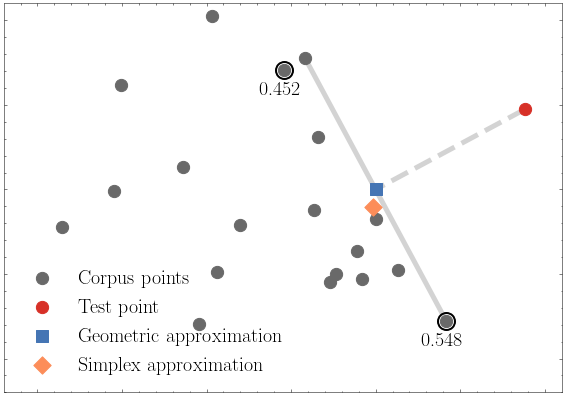

In [145]:
# generate some plots of simple 2d examples

n_keep = 5
point_size = 150
line_width = 5
text_size = 20
delta = -0.15
seed=10


corpus, test_point = generate_data(dim=2, corpus_size=20, num_sv=2, seed=seed)

proj_hull_, weights_ = corpus_decomposition(corpus, test_point)
proj_hull, weights = fit_simplex_np(corpus, test_point, n_keep=n_keep)

plt.figure(figsize=(10,10))
ax = plt.gca()

ax.set_aspect('equal',adjustable='box')
plt.plot(corpus[:2,0], corpus[:2,1], c='lightgrey', zorder=-1, linewidth=line_width)

ax.scatter(corpus[:,0], corpus[:,1], c='dimgrey', s=point_size, label='Corpus points')
x_values = [test_point[0], proj_hull_[0]]
y_values = [test_point[1], proj_hull_[1]]
plt.plot(x_values, y_values, zorder=-1, linestyle='--', c='lightgrey', linewidth=line_width)
plt.scatter(test_point[0], test_point[1], c='#d73027', s=point_size, label='Test point')
plt.scatter(proj_hull_[0],proj_hull_[1], c='#4575b4', s=point_size, marker="s", label='Geometric approximation')
plt.scatter(proj_hull[0],proj_hull[1], c='#fc8d59', s=point_size, marker="D", label='Simplex approximation')
plt.legend(prop={'size': 20})
ax.tick_params(labelbottom=False, labelleft=False) 
plt.ylim(-0.2,2.1)
plt.xlim(-1.2, 2.1)
for i, w in enumerate(weights):
    if w > 0.05:
        w = round(w,3)
        ax.plot(corpus[i:i+1,0], corpus[i:i+1,1], 'o', ms=17, mec='black', mfc='none', mew=2)
        ax.annotate(w, (corpus[i,0] + delta, corpus[i,1] + delta), fontsize=text_size)
plt.savefig(f'sample_{n_keep}.pdf', format='pdf', dpi=1200)
plt.show()

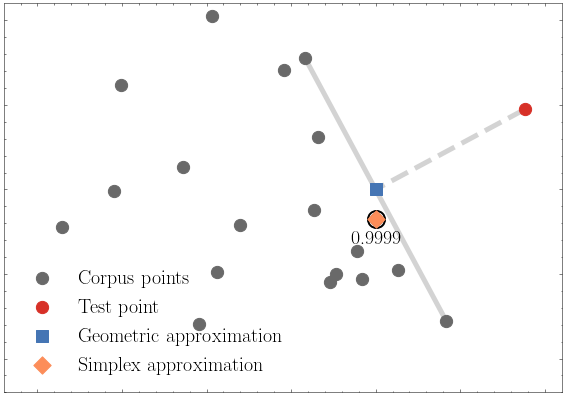

In [146]:
n_keep = 2
point_size = 150
line_width = 5
text_size = 20
delta = -0.15

seed=10
corpus, test_point = generate_data(dim=2, corpus_size=20, num_sv=2, seed=seed)

proj_hull_, weights_ = corpus_decomposition(corpus, test_point)
proj_hull, weights = fit_simplex_np(corpus, test_point, n_keep=n_keep)

plt.figure(figsize=(10,10))
ax = plt.gca()

ax.set_aspect('equal',adjustable='box')
plt.plot(corpus[:2,0], corpus[:2,1], c='lightgrey', zorder=-1, linewidth=line_width)

ax.scatter(corpus[:,0], corpus[:,1], c='dimgrey', s=point_size, label='Corpus points')
x_values = [test_point[0], proj_hull_[0]]
y_values = [test_point[1], proj_hull_[1]]
plt.plot(x_values, y_values, zorder=-1, linestyle='--', c='lightgrey', linewidth=line_width)
plt.scatter(test_point[0], test_point[1], c='#d73027', s=point_size, label='Test point', zorder=20)
plt.scatter(proj_hull_[0],proj_hull_[1], c='#4575b4', s=point_size, marker="s", label='Geometric approximation', zorder=20)
plt.scatter(proj_hull[0],proj_hull[1], c='#fc8d59', s=point_size, marker="D", label='Simplex approximation', zorder=20)
plt.legend(prop={'size': 20})
ax.tick_params(labelbottom=False, labelleft=False) 
plt.ylim(-0.2,2.1)
plt.xlim(-1.2, 2.1)
for i, w in enumerate(weights):
    if w > 0.05:
        w = round(w,4)
        ax.plot(corpus[i:i+1,0], corpus[i:i+1,1], 'o', ms=17, mec='black', mfc='none', mew=2)
        ax.annotate(w, (corpus[i,0] + delta, corpus[i,1] + delta), fontsize=text_size)
plt.savefig(f'sample_{n_keep}.pdf', format='pdf', dpi=1200)
plt.show()